In [9]:
import os
print(os.getcwd())

import torch
from src_.utils import  rank_gradient_info
from src.manipulator._style_gan_manipulator.legacy import load_network_pkl
from src_.backpropagation import backpropagation_gradients_s_space
import matplotlib.pyplot as plt
plt.style.use('dark_background')
# ==== load StyleGAN's mapping and synthesis networks ====
# mapping: z -> w (shape: [1, latent_dim] -> [1, num_layers, 512])
# synthesis: takes per-layer w
# f = open("local_models/generators/imagenet128.pkl", "rb")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device ", device)
ckpt_path = "../local_models/generators/stylegan3-r-afhqv2-512x512.pkl"
# load generator

with open(ckpt_path, 'rb') as f:
    generator = load_network_pkl(f)['G_ema'].to(device)  # type: ignore


/tmp/pycharm_project_181
device  cuda


/tmp/pycharm_project_181/src/manipulator/_style_gan_manipulator/legacy.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_lo

Setting up PyTorch plugin "bias_act_plugin"... 

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


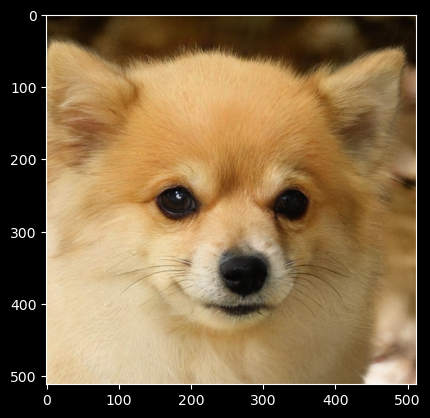

In [3]:
# generate latent vector and class label
z = torch.randn([1, generator.z_dim], device=device)

if generator.c_dim != 0:
    label = torch.zeros([1, generator.c_dim], device=device)

    target_class = 15  #  SELECT CLASS
    label[:, target_class] = 1
else:
    label = None

img_tensor = generator(z, label, truncation_psi=0.7, noise_mode='const')
img_tensor = (img_tensor.clamp(-1, 1) + 1) / 2  # normalize to [0, 1] ss
# save_image(img, 'stylegan_xl_sample.png')

img = img_tensor.cpu().detach().numpy()[0]
img = img.transpose(1, 2, 0)

plt.imshow(img)



In [4]:
import torchvision.models as models
from torchvision import transforms
classifier = models.resnet18(pretrained=True).eval().to(device)

preprocess_classifier = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def get_labels(id, path = "local_models/classifiers/imagenet1000_clsidx_to_labels.txt"):
    with open(path, "r") as f:
        labels = f.readlines()
        labels = [x.strip() for x in labels]
    return labels[id]

In [11]:
outputs = classifier(preprocess_classifier(img_tensor))
# top 2 predictions
prediction = outputs.argmax(1).squeeze(0)
top2_probs, top2_classes = torch.topk(outputs, 2)
top2_probs = top2_probs.squeeze(0)
top2_classes = top2_classes.squeeze(0)
confidence = outputs[0][prediction]
print(prediction, confidence)
print(top2_probs, top2_classes)
print(f"Top 1st {top2_classes[0]} {get_labels(top2_classes[0])} confidence {top2_probs[0]:.2f},\nTop 2nd {top2_classes[1]} {get_labels(top2_classes[1])} confidence {top2_probs[1]:.2f}")


tensor(259, device='cuda:0') tensor(16.5690, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([16.5690, 13.6839], device='cuda:0', grad_fn=<SqueezeBackward1>) tensor([259, 151], device='cuda:0')
Top 1st 259 259: 'Pomeranian', confidence 16.57,
Top 2nd 151 151: 'Chihuahua', confidence 13.68


In [8]:
w = generator.mapping(z, c=label)

s_gradients, classifier_output, img_tensor = backpropagation_gradients_s_space(
    synthesis_net = generator.synthesis,
    classifier = classifier,
    preprocess= preprocess_classifier,
    w_latents= w,
    target_class= top2_classes[0], # glasses
)

In [10]:
ranked_gradient_info = rank_gradient_info(s_gradients)
#print(gradient_info_by_layer['input.affine'])
print(ranked_gradient_info)

{'input.affine': {'ranked_indices': [2, 3, 0, 1], 'gradients': [-7.846199035644531, -4.136730670928955, -2.5530638694763184, -0.6838660836219788]}, 'L0_36_1024.affine': {'ranked_indices': [676, 334, 901, 28, 323], 'gradients': [0.13433386385440826, -0.05499769374728203, 0.04283278435468674, 0.04183066263794899, 0.04066740348935127]}, 'L1_36_1024.affine': {'ranked_indices': [782, 489, 964, 21, 322], 'gradients': [-0.0469323992729187, -0.044285330921411514, 0.04060182347893715, -0.03568875417113304, -0.03389561176300049]}, 'L2_52_1024.affine': {'ranked_indices': [791, 286, 634, 700, 542], 'gradients': [0.05691536143422127, 0.0559953898191452, 0.05028732493519783, 0.046027787029743195, 0.03972809389233589]}, 'L3_52_1024.affine': {'ranked_indices': [704, 936, 357, 107, 764], 'gradients': [-0.08424482494592667, -0.07814521342515945, -0.07808487862348557, -0.07644529640674591, -0.07560133934020996]}, 'L4_84_1024.affine': {'ranked_indices': [871, 991, 20, 227, 999], 'gradients': [0.1446928679

In [8]:
from src_.manipulator_binary import ManipulatorSSpace

manipulator = ManipulatorSSpace(generator, classifier, preprocess_classifier)

manipulator = ManipulatorSSpace(
        generator=generator,
        classifier=classifier,
        segmenter=None,
        preprocess_fn=preprocess_classifier,
        target_logit=  top2_classes[0],
        save_dir="",
        device=device
    )


data_path = os.path.join(base_dir, f"{target_logit}_{celeba_attributes_dict[target_logit]}",
                         f"{torch_seed}")
manipulator.save_dir = data_path
# os.makedirs(data_path, exist_ok=True)

manipulator.handle_one_seed(
    torch_seed=torch_seed,
    target_logit=target_logit,
    top_channels=top_channels,
    default_extent_factor=40,
    tolerance_of_extent_bisection=1,
    confidence_drop_threshold=0.3,
    specified_layer=None,
)


array([1.57079633, 4.71238898])

tensor([[[ 0.9955, -0.0952],
         [ 0.9907,  0.1360]]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-6.9834,  7.1268]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[-0.0270, -0.0052,  0.0164]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
[0.99071264 0.13597234]
[-6.9833574  7.126841 ]
[-0.0270381  -0.00523694  0.01642672]


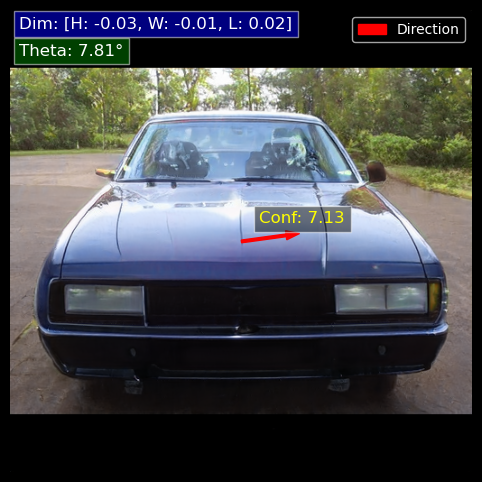

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def generate_bins(bins):
    angle_bins = np.zeros(bins)
    interval = 2 * np.pi / bins
    for i in range(1,bins):
        angle_bins[i] = i * interval
    angle_bins += interval / 2 # center of the bin

    return angle_bins
angle_bins = generate_bins(2)
def visualize_prediction(img, orient, conf, dim):
    """
    Visualize prediction results on an image, including orientations, confidence, and dimensions.

    Args:
        img (numpy.ndarray): The input image on which to overlay the visualizations.
        orient (list/tuple): The orientation vector [sin(theta), cos(theta)].
        conf (list/tuple): Confidence values for different orientation bins.
        dim (list/tuple): The 3D dimensions of the object [height, width, length].
    """
    # Calculate the direction angle (radians to degrees)
    cos, sin = orient
    alpha = np.arctan2(sin, cos)  # Base angle (alpha)

    # Step 2: If angle_bins are provided, adjust the angle based on the highest confidence bin
    if angle_bins is not None:
        # Extract the bin with the highest confidence
        argmax = np.argmax(conf)  # Index of the highest confidence value
        #alpha -= angle_bins[argmax]  # Add the angle correction from the bins
        #alpha += np.pi  # Normalize angle (if needed) to range [-π, π]

    theta_deg = np.degrees(alpha)  # Convert to degrees

    # Retrieve the index with the highest confidence
    max_conf_idx = np.argmax(conf)  # Index of the bin with the highest confidence
    max_conf = conf[max_conf_idx]  # Corresponding confidence value

    # Get the dimensions of the input image
    height, width, _ = img.shape

    # Plot the image with overlays
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis("off")

    # Draw an arrow to indicate orientation
    center = (width // 2, height // 2)  # Arrow starting position at the center of the image
    arrow_length = 50  # Length of the arrow
    arrow_dx = arrow_length * np.cos(alpha)
  # Arrow's x length component
    arrow_dy = -arrow_length * np.sin(alpha)
  # Arrow's y length component (negative y due to image coordinates)
    plt.arrow(center[0], center[1], arrow_dx, arrow_dy, color='red', width=3, head_width=10, label="Direction")

    # Display the confidence value near the center of the arrow
    text_x = center[0] + 20  # Position slightly offset from the arrow's center
    text_y = center[1] - 20
    plt.text(
        text_x, text_y, f"Conf: {max_conf:.2f}", color="yellow", fontsize=12,
        bbox=dict(facecolor='black', alpha=0.5)  # Create a background for better visibility
    )

    # Display the object's dimensions
    dim_text = f"Dim: [H: {dim[0]:.2f}, W: {dim[1]:.2f}, L: {dim[2]:.2f}]"
    plt.text(
        10, 20, dim_text, color="white", fontsize=12,
        bbox=dict(facecolor='blue', alpha=0.5)
    )

    # Display the orientation angle (degrees)
    theta_text = f"Theta: {theta_deg:.2f}°"
    plt.text(
        10, 50, theta_text, color="white", fontsize=12,
        bbox=dict(facecolor='green', alpha=0.5)
    )

    plt.legend(["Direction"], loc="upper right")
    plt.show()


[orient, conf, dim] = model(vgg19_preprocess(img_tensor))
print(orient, conf, dim)
# Example usage
# Example image as a blank canvas

orient = orient.cpu().data.numpy()[0, :, :]
conf = conf.cpu().data.numpy()[0, :]
dim = dim.cpu().data.numpy()[0, :]
argmax = np.argmax(conf)
orient = orient[argmax, :]
cos = orient[0]
sin = orient[1]

print(orient)
print(conf)
print(dim)
# Call the visualization method to overlay the prediction information on the image
visualize_prediction(img, orient, , -0.0952],
         [ 0.9907,  0.1360]]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-6.9834,  7.1268]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[-0.0270, -0.0052,  0.0164]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
[0.99071264 0.13597234]
[-6.9833574  7.126841 ]
[-0.0270381  -0c,  0.1360]]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-6.9834,  7.1268]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[-0.0270, -0.0052,  0.0164]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
[0.99071264 0.13597234]
[-6.9833574  7.126841 ]
[-0.0270381  -0.0052369onf, dim)

In [17]:

from models.orientation_src.Plotting import plot_3d_box, plot_2d_box
from models.orientation_src.Math import calc_location

def plot_regressed_3d_bbox(img, cam_to_img, box_2d, dimensions, alpha, theta_ray, img_2d=None):

    location, X = calc_location(dimensions, cam_to_img, box_2d, alpha, 0 if theta_ray is None else theta_ray)

    orient = alpha if theta_ray is None else alpha + theta_ray

    if img_2d is not None:
        plot_2d_box(img_2d, box_2d)

    plot_3d_box(img, cam_to_img, orient, dimensions, location)  # 3d boxes

    return location


 Train segmentation model

In [19]:

import numpy as np

[orient, conf, dim] = model(vgg19_preprocess(img_tensor))
orient = orient.cpu().data.numpy()[0, :, :]
conf = conf.cpu().data.numpy()[0, :]
dim = dim.cpu().data.numpy()[0, :]

#dim += averages.get_item(label['Class'])
angle_bins = generate_bins(2)
argmax = np.argmax(conf)
orient = orient[argmax, :]
cos = orient[0]
sin = orient[1]
alpha = np.arctan2(sin, cos)
alpha += angle_bins[argmax]
alpha -= np.pi


print('Estimated pose: %s'%location)
print('Truth pose: %s'%label['Location'])
print('-------------')
cam_to_img = np.array([
    [1000, 0, 640],  # 水平焦距 fx = 1000，主点 cx = 640
    [0, 1000, 360],  # 垂直焦距 fy = 1000，主点 cy = 360
    [0, 0, 1]        # 齐次坐标的归一化项
])
location, X = calc_location(dim, cam_to_img, box_2d, alpha, theta_ray)

plot_3d_box(img, cam_to_img, orient, dim, location)
# plot car by car


NameError: name 'location' is not defined

In [3]:
"""from ultralytics import YOLO

# Load a pretrained segmentation model like YOLO11n-seg
model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)

# Train the model on the Carparts Segmentation dataset
results = model.train(data="carparts-seg.yaml", epochs=100, imgsz=640)

# After training, you can validate the model's performance on the validation set
results = model.val()

# Or perform prediction on new images or videos
results = model.predict("path/to/your/image.jpg")"""

'from ultralytics import YOLO\n\n# Load a pretrained segmentation model like YOLO11n-seg\nmodel = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)\n\n# Train the model on the Carparts Segmentation dataset\nresults = model.train(data="carparts-seg.yaml", epochs=100, imgsz=640)\n\n# After training, you can validate the model\'s performance on the validation set\nresults = model.val()\n\n# Or perform prediction on new images or videos\nresults = model.predict("path/to/your/image.jpg")'

Test classifiers

In [4]:
"""classifier_path = "local_models/classifiers/checkpoints/VehicleTypeNet_resnet18_pruned.onnx"
from onnx2torch import convert
import torch
from torchvision import transforms
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
torch_model = convert(classifier_path)

# save the model
torch.save(torch_model, "local_models/classifiers/VehicleTypeNet_resnet18_pruned.pt")"""

'classifier_path = "models/classifiers/checkpoints/VehicleTypeNet_resnet18_pruned.onnx"\nfrom onnx2torch import convert\nimport torch\nfrom torchvision import transforms\nfrom torchvision import transforms\nfrom torchvision.transforms.functional import InterpolationMode\ntorch_model = convert(classifier_path)\n\n# save the model\ntorch.save(torch_model, "models/classifiers/VehicleTypeNet_resnet18_pruned.pt")'

In [5]:
"""# load label dictionary
import csv

with open("local_models/classifiers/tresnet_v2/labels.csv", "r") as f:
    reader = csv.reader(f)
    #next(reader)
    # skip header
    labels = {i: row for i,row in enumerate(reader) if row[0] != ''}

classifier_path = "local_models/classifiers/checkpoints/stanford_cars_tresnet-l-v2_96_27.pth"
num_classes = 196
from local_models.classifiers.tresnet_v2.tresnet_v2 import TResnetL_V2
model = TResnetL_V2(num_classes=num_classes)
state = torch.load(classifier_path, map_location='cpu',weights_only=True)['model']
model.load_state_dict(state, strict=False)
model = model.to(device)"""

'# load label dictionary\nimport csv\n\nwith open("models/classifiers/tresnet_v2/labels.csv", "r") as f:\n    reader = csv.reader(f)\n    #next(reader)\n    # skip header\n    labels = {i: row for i,row in enumerate(reader) if row[0] != \'\'}\n\nclassifier_path = "models/classifiers/checkpoints/stanford_cars_tresnet-l-v2_96_27.pth"\nnum_classes = 196\nfrom models.classifiers.tresnet_v2.tresnet_v2 import TResnetL_V2\nmodel = TResnetL_V2(num_classes=num_classes)\nstate = torch.load(classifier_path, map_location=\'cpu\',weights_only=True)[\'model\']\nmodel.load_state_dict(state, strict=False)\nmodel = model.to(device)'

In [6]:
"""from torchvision import transforms
preprocess_classifier = transforms.Compose(
            [transforms.Resize(int(368/0.875)),
             transforms.CenterCrop(368)
             ])
outputs = model(preprocess_classifier(img_tensor))

print(f"{outputs.argmax(1),  outputs.max(1).values} label: {labels[int(outputs.argmax(1).cpu().detach())]}")"""

'from torchvision import transforms\npreprocess_classifier = transforms.Compose(\n            [transforms.Resize(int(368/0.875)),\n             transforms.CenterCrop(368)\n             ])\noutputs = model(preprocess_classifier(img_tensor))\n\nprint(f"{outputs.argmax(1),  outputs.max(1).values} label: {labels[int(outputs.argmax(1).cpu().detach())]}")'

In [7]:
labels

NameError: name 'labels' is not defined